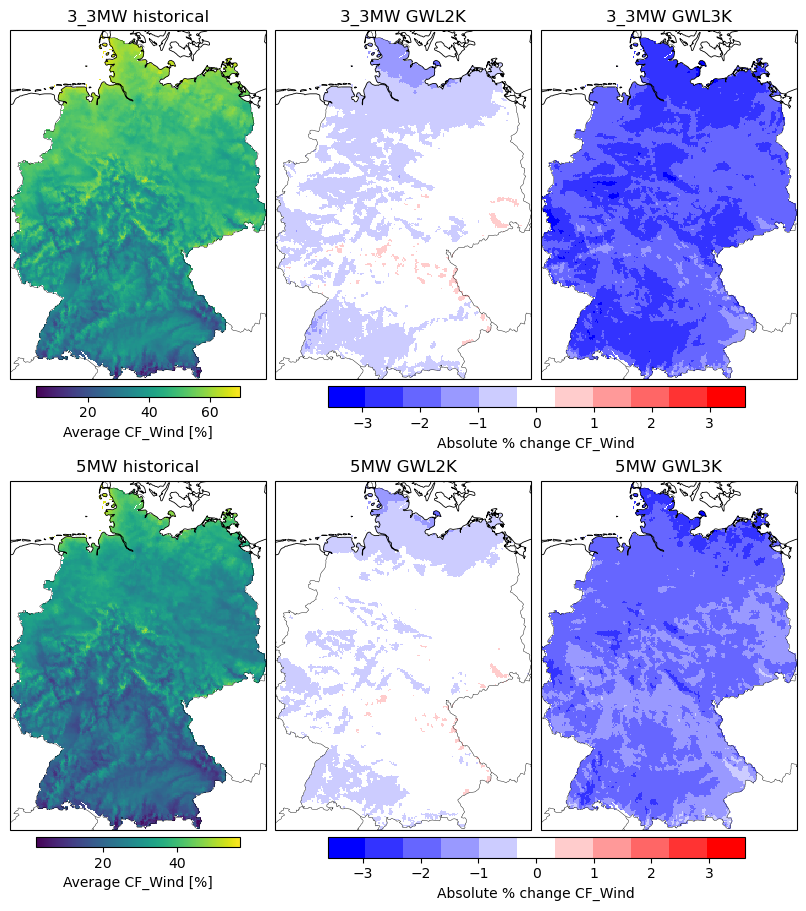

KeyError: 'historical'

In [ ]:
# Changes to CF_Wind
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(pole_longitude=198.0, pole_latitude=39.25)

turbine_list = ["3_3MW", "5MW"]

# ← MOVE fig CREATION OUTSIDE the loop, use 2 rows × 3 cols
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(14, 9),
    subplot_kw=dict(projection=rotated_pole),
    layout="compressed",
)

discrete_cmap = plt.get_cmap("bwr", 11)
discrete_cmap.set_bad(color=(0, 0, 0, 0))

# READ JSON once
with open("CF_Wind/Germany.json", "r", encoding="utf-8") as file:
    file_locations = json.load(file)

for i, turbine in enumerate(turbine_list):
    # exactly your old lookup
    data_location = file_locations[turbine][
        "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_Wind"
    ]

    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
    file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])



    print(
        f"Mean value historical {turbine}: {np.nanmean(file_1['CF_Wind'].values)*100:.2f}%"
    )
    print(f"Mean value GWL2K {turbine}: {file_2['CF_Wind'].mean().item()*100:.2f}%")
    print(f"Mean value GWL3K {turbine}: {file_3['CF_Wind'].mean().item()*100:.2f}%")
    print(f"Mean difference GWL2K {turbine}: {np.nanmean(GWL2K)*100:.2f}%")
    print(f"Mean difference GWL3K {turbine}: {np.nanmean(GWL3K)*100:.2f}%")

    historical = file_1["CF_Wind"].values * 100
    GWL2K = (file_2["CF_Wind"].values - file_1["CF_Wind"].values) * 100
    GWL3K = (file_3["CF_Wind"].values - file_1["CF_Wind"].values) * 100

    # same vmin/vmax logic
    v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K))
    v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K))
    v_max = max(abs(v_min), abs(v_max))
    v_min = -v_max

    files = [GWL2K, GWL3K]
    scenarios = ["GWL2K", "GWL3K"]

    lon = file_1["lon"].values
    lat = file_1["lat"].values

    # --- historical subplot in row i, col 0
    ax = axes[i, 0]
    cf_masked = np.squeeze(np.ma.masked_equal(historical, 0))
    pm1 = ax.pcolormesh(
        lon,
        lat,
        cf_masked,
        cmap="viridis",
        vmin=np.floor(np.nanmin(cf_masked)),
        vmax=np.ceil(np.nanmax(cf_masked)),
        shading="auto",
        transform=ccrs.PlateCarree(),
    )
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.set_title(f"{turbine} historical", fontsize=12)

    # --- future scenarios in cols 1 & 2
    for idx, (arr, scenario) in enumerate(zip(files, scenarios)):
        ax = axes[i, idx + 1]
        cf_masked = np.squeeze(np.ma.masked_equal(arr, 0))
        pm = ax.pcolormesh(
            lon,
            lat,
            cf_masked,
            cmap=discrete_cmap,
            vmin=v_min,
            vmax=v_max,
            shading="auto",
            transform=ccrs.PlateCarree(),
        )
        ax.coastlines(linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.set_title(f"{turbine} {scenario}", fontsize=12)

    # per‐row colorbars
    fig.colorbar(
        pm1,
        ax=axes[i, 0],
        orientation="horizontal",
        pad=0.02,
        shrink=0.8,
        label="Average CF_Wind [%]",
    )
    fig.colorbar(
        pm,
        ax=axes[i, 1:].ravel().tolist(),
        orientation="horizontal",
        pad=0.02,
        shrink=0.8,
        label="Absolute % change CF_Wind",
    )

# SAVE & SHOW once, combined
plt.savefig(
    "Publikation/Figures/CF_Wind_combined.png",
    bbox_inches="tight",
    dpi=300,
    format="png",
)
plt.show()

